In [1]:
#-*- coding=utf-8 -*-
import xml.etree.ElementTree as ET
import glob,os
import pprint
import pandas as pd
import time
import random
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import shutil
import math
import datetime
from sklearn import cross_validation,metrics
from scipy import interp
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold


seed=17
random.seed(seed)
np.random.seed(seed)


#遍历指定文件夹包括其子文件夹，寻找某种后缀的文件，并返回找到的文件路径列表
def traverse_dir_suffix(dirPath, suffix):
    suffixList = []
    for (root, dirs, files)in os.walk(dirPath):
            findList = glob.glob(root+'\\*.'+suffix)
            for f in findList:
                suffixList.append(f)
    return suffixList

#读取1个xml文件，输出瑕疵坐标列表和瑕疵类型列表，格式为：[[瑕疵类型1，瑕疵1坐标，瑕疵1面积占比]，...]；
def read_xml(xmlPath):
    tree = ET.parse(xmlPath)
    root = tree.getroot()
    defectList = []
    for child in root.findall('object'):
        bndbox=child.find('bndbox')
        bndboxXY = [int(bndbox.find('xmin').text),int(bndbox.find('ymin').text),
                    int(bndbox.find('xmax').text),int(bndbox.find('ymax').text)]
        defectList.append([child.find('name').text, bndboxXY, 1.0])
    return defectList

def gen_xmlDict(xmlPath):
    #读取所有xml文件，若xml文件存在，则为瑕疵图片，xml文件不存在，则为正常图片，
    #生成的每张图片的Dict格式如下：
    #{"isNormalImg": false, "defectList": [["油渍", [1113, 812, 1598, 1273], 1.0], ["线印", [918, 427, 1003, 546], 1.0], ["线印", [1059, 436, 1132, 515], 1.0]]}
    imgPath = xmlPath.replace('xml', 'jpg')
    #h,w,c = cv_imread(imgPath).shape
    h,w=1920,2560
    xmlDict = {}
    filename = os.path.split(imgPath)[1]
    #xmlDict['imgPath'] = imgPath
    if os.path.exists(xmlPath):
        xmlDict['isNormalImg'] = False
        #xmlDict['xmlPath'] = xmlPath
        defectList = read_xml(xmlPath)
    else:
        xmlDict['isNormalImg'] = True
        #xmlDict['xmlPath'] = ''
        defectList = [["正常", [0, 0, w, h], 1.0]]
    #xmlDict['filename'] = filename 
    #xmlDict['imgPath'] = imgPath 
    xmlDict['defectList'] = defectList 
    return xmlDict
    
def cal_area(box):#box = [xmin,ymin,xmax,ymax]#用于计算box的面积
    if box == []:
        area =0
    else:
        [xb1,yb1,xb2,yb2] = box
        area = (xb2-xb1)*(yb2-yb1)
    return area 

def gen_cutDict(cutXY, defectList):
    #用于生成切割后图片信息，给定切割的坐标和图片中瑕疵信息，就能判断该切割图片中是否包含瑕疵，包含的瑕疵面积占完整瑕疵总面积的比例
    [x1,y1,x2,y2] = cutXY 
    cutDict={}
    cutDefectList=[]
    for defect in defectList:
        cutDefect=[]
        defectType, defectBox, defectRatio = defect
        [xb1,yb1,xb2,yb2] = defectBox
        defectArea = cal_area(defectBox)
        assert x1<x2 and y1<y2 and xb1<xb2 and yb1<yb2, 'x1<x2, y1<y2 need to be satisfied'
        if x2<=xb1 or xb2<=x1 or y2<=yb1 or yb2<=y1:#bndbox在切割后的图片外面
            cutDefectBox = []
        else:
            if xb1<=x1 and x1<=xb2 and xb2<=x2 and yb1<=y1 and y1<=yb2 and yb2<=y2:#1-4:xb1<=x1<=xb2<=x2
                cutDefectBox = [x1,y1,xb2,yb2]
    
            elif xb1<=x1 and x1<=xb2 and xb2<=x2 and y1<=yb1 and yb1<=yb2 and yb2<=y2:
                cutDefectBox = [x1,yb1,xb2,yb2]
    
            elif xb1<=x1 and x1<=xb2 and xb2<=x2 and y1<=yb1 and yb1<=y2 and y2<=yb2:
                cutDefectBox = [x1,yb1,xb2,y2]
    
            elif xb1<=x1 and x1<=xb2 and xb2<=x2 and yb1<=y1 and y1<=y2 and y2<=yb2:
                cutDefectBox = [x1,y1,xb2,y2]
    
            elif x1<=xb1 and xb1<=xb2 and xb2<=x2 and yb1<=y1 and y1<=yb2 and yb2<=y2:#5-8:x1<=xb1<=xb2<=x2
                cutDefectBox = [xb1,y1,xb2,yb2]

            elif x1<=xb1 and xb1<=xb2 and xb2<=x2 and y1<=yb1 and yb1<=yb2 and yb2<=y2:
                cutDefectBox = [xb1,yb1,xb2,yb2]
        
            elif x1<=xb1 and xb1<=xb2 and xb2<=x2 and y1<=yb1 and yb1<=y2 and y2<=yb2:
                cutDefectBox = [xb1,yb1,xb2,y2]
    
            elif x1<=xb1 and xb1<=xb2 and xb2<=x2 and yb1<=y1 and y1<=y2 and y2<=yb2:
                cutDefectBox = [xb1,y1,xb2,y2]
    
            elif x1<=xb1 and xb1<=x2 and x2<=xb2 and yb1<=y1 and y1<=yb2 and yb2<=y2:#9-12:x1<=xb1<=x2<=xb2
                cutDefectBox = [xb1,y1,x2,yb2]
            
            elif x1<=xb1 and xb1<=x2 and x2<=xb2 and y1<=yb1 and yb1<=yb2 and yb2<=y2:
                cutDefectBox = [xb1,yb1,x2,yb2]
    
            elif x1<=xb1 and xb1<=x2 and x2<=xb2 and y1<=yb1 and yb1<=y2 and y2<=yb2:
                cutDefectBox = [xb1,yb1,x2,y2]
    
            elif x1<=xb1 and xb1<=x2 and x2<=xb2 and yb1<=y1 and y1<=y2 and y2<=yb2:
                cutDefectBox = [xb1,y1,x2,y2]
    
            elif xb1<=x1 and x1<=x2 and x2<=xb2 and yb1<=y1 and y1<=yb2 and yb2<=y2:#13-16:xb1<=x1<=x2<=xb2
                cutDefectBox = [x1,y1,x2,yb2]
    
            elif xb1<=x1 and x1<=x2 and x2<=xb2 and y1<=yb1 and yb1<=yb2 and yb2<=y2:
                cutDefectBox = [x1,yb1,x2,yb2]
    
            elif xb1<=x1 and x1<=x2 and x2<=xb2 and y1<=yb1 and yb1<=y2 and y2<=yb2:
                cutDefectBox = [x1,yb1,x2,y2]
        
            elif xb1<=x1 and x1<=x2 and x2<=xb2 and yb1<=y1 and y1<=y2 and y2<=yb2:
                cutDefectBox = [x1,y1,x2,y2]   
            else:
                print('Error: Bonbox out of range: CutXY:%s; bndbox:%s'%(cutXY,bndbox))
                cutDefectBox = [xb1,yb1,xb2,yb2] 
       
        cutDefectArea = cal_area(cutDefectBox)
        cutDefectRatio = round(cutDefectArea/defectArea,4)
        if cutDefectBox!=[]:
            cutDefectBox_ab = [cutDefectBox[0]-x1, cutDefectBox[1]-y1,cutDefectBox[2]-x1,cutDefectBox[3]-y1]#转换成绝对坐标
            cutDefect = [defectType, cutDefectBox_ab, cutDefectRatio*defectRatio]
            cutDefectList.append(cutDefect)
     
    if cutDefectList==[]:
        cutDefectList.append(['正常',[0,0,x2-x1,y2-y1],1])
    cutDict['defectList']= cutDefectList
    cutDict['isNormalImg'] = True if cutDict['defectList'][0][0]=='正常' else False

    return cutDict

def sav_to_csv(xmlDict,csvSavPath):
    head = ['filename','imgPath','isNormalImg','defectList','bndboxRatio','inBndboxArea']
    #head = ['filename','imgPath','isNormalImg']
    csvlist = []
    for key in xmlDict: 
        csvlist.append(xmlDict[key])
    
    df = pd.DataFrame(columns=head, data=csvlist)
    df.to_csv(csvSavPath,index=False,encoding="gbk",)
    return

def draw_one_bndbox(img, bndbox, bndNum):#由于不能输入中文，所以框的text为其在xml中的序号
    #用于将图片中的瑕疵框出，方便可视化
    min_x,min_y,max_x,max_y = bndbox
    cv2.rectangle(img,(min_x,min_y),(max_x,max_y),(255,0,0),3)
    font=cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, str(bndNum), (int((min_x+max_x)*0.5),int(min_y+(max_y-min_y)/4)), font, 1,(255,255,0),2)
    return img

def plt_img(img):
    img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #plt.figure(figsize=(20,20))
    plt.figure()
    plt.imshow(img_rgb)  
    plt.show() 
    
def sav_img(imgSavPath, img):
    savDir = os.path.split(imgSavPath)[0]
    if not os.path.exists(savDir):
        os.makedirs(savDir)
    cv2.imencode('.jpg', img)[1].tofile(imgSavPath)
    return

def cv_imread(filePath):
    #由于路径有中文，所以用该函数读取
    cv_img=cv2.imdecode(np.fromfile(filePath,dtype=np.uint8),-1)
    ## imdecode读取的是rgb，如果后续需要opencv处理的话，需要转换成bgr，转换后图片颜色会变化
    #cv_img=cv2.cvtColor(cv_img,cv2.COLOR_RGB2BGR)
    return cv_img


def copy_file(srcfile, savDir):
    if not os.path.isfile(srcfile):#检测要复制的文件是否存在
        pass
    else:
        if not os.path.exists(savDir):
            os.makedirs(savDir)
        filename = os.path.split(srcfile)[1]
        shutil.copyfile(srcfile,savDir+'\\'+filename)
    return True

def random_split(splitDir, trainPerc):
    #trainPerc：训练集所占总数的比例
    imgList = glob.glob(splitDir+'\\*.jpg')
    imgNum = len(imgList)
    random.shuffle(imgList)
    if imgNum ==1:
        trainList = imgList
        valicList = []
    else:
        i = max(round((1-trainPerc)*imgNum),1)
        valicList = imgList[:i]
        trainList = imgList[i:]
        
    #print('type:%5s, trainNum:%5d, valicNum:%5d'%(os.path.split(splitDir)[1],len(trainList),len(valicList)))
    return trainList, valicList

def gen_data_group(srcDir, savDir, typeNum=0, dirClear=True):
    #typeNum: 选择输出多少类别的瑕疵，默认为0输出全部，比如为5，则输出数量最多的5个类别
    #dirClear：是否先清空savDir中的所有文件
    subDirList = []
    for root,dirs,files in os.walk(srcDir):
        subDirList.append(root)
    del subDirList[0]#第一个是原目录，删除
    imgNumList =[len(glob.glob(subDir+'\\*.jpg')) for subDir in subDirList]
    idxSortedList = np.argsort(imgNumList)[::-1]#将子文件夹按文件多少从大到小排序
    if typeNum!= 0:
        typeNum = min(typeNum, len(subDirList))
        idxSortedList = idxSortedList[:typeNum]
    trainList = []
    valicList = []
    for i in idxSortedList:
        subDir = subDirList[i]
        if len(glob.glob(subDir+'\\*jpg'))>0:
            subTrainList, subValicList = random_split(subDir, 0.9)
            trainList +=subTrainList
            valicList +=subValicList
    #清空保存的文件夹
    if dirClear ==True and os.path.exists(savDir):
        shutil.rmtree(savDir)
    #复制img同时生成json文件
    trainSavDir = savDir +'\\train'
    valicSavDir = savDir +'\\valic'
    for i, imgPath in enumerate(trainList):
        if copy_file(imgPath, trainSavDir)==0:
            print('%s coppy failed.'%(imgPath))
        xmlPath = imgPath.replace('jpg','xml')
        jsonname = os.path.split(imgPath)[1].replace('.jpg','.json')
        imgDict = gen_xmlDict(xmlPath)
        with open(trainSavDir+'\\'+jsonname,'w',encoding='utf-8') as jsonfile:
            json.dump(imgDict, jsonfile, ensure_ascii=False)
        if i+1<len(trainList):
            print('Splitting train set %d/%d'%(i+1,len(trainList)),end = '\r')
        else:
            print('Splitting train set %d/%d'%(i+1,len(trainList)))
        
    for i, imgPath in enumerate(valicList):
        if copy_file(imgPath, valicSavDir)==0:
            print('%s coppy failed.'%(imgPath))
        xmlPath = imgPath.replace('jpg','xml')
        jsonname = os.path.split(imgPath)[1].replace('.jpg','.json')
        imgDict = gen_xmlDict(xmlPath)
        with open(valicSavDir+'\\'+jsonname,'w',encoding='utf-8') as jsonfile:
            json.dump(imgDict, jsonfile, ensure_ascii=False)  
        if i+1<len(valicList):
            print('Splitting valic set %d/%d'%(i+1,len(valicList)),end = '\r')
        else:
            print('Splitting valic set %d/%d'%(i+1,len(valicList)))
        
def gen_cutXY_list(w,cutw,step):
    #根据切割大小，和步长，生成x或y坐标的list
    a = list(range(0,w,step))
    a.append(w-cutw)
    a = list(set(a))#去重
    a.sort() 
    xList = a[:(a.index(w-cutw)+1)]
    return xList
    
def cut_step(imgPath, cuth, cutw, cutStep, defectAreaP, normalNumP,cutRamdomList, savDir, drawBox=False):
    filename = os.path.split(imgPath)[1]
    img = cv_imread(imgPath)
    h,w,c = img.shape
    xList = gen_cutXY_list(w,cutw,cutStep)
    yList = gen_cutXY_list(h,cuth,cutStep)
    cutId = 0
    jsonPath = imgPath.replace('jpg','json')
    with open(jsonPath,'r',encoding='utf-8') as jsonfile:
        imgDict=json.load(jsonfile)
        defectList = imgDict['defectList']
    for y1 in yList:
        for x1 in xList:
            cutFilename = filename[:-4]+'_'+str(cutId)+'.jpg'
            cutJsonname = cutFilename.replace('jpg','json')
            x2,y2 = x1+cutw,y1+cuth
            cutXY = [x1,y1,x2,y2]
            cutImg = img[y1:y2,x1:x2]
            cutDict = gen_cutDict(cutXY, defectList)
            cutDefectList = cutDict['defectList']
            if drawBox==True and cutDefectList[0][0]!='正常':
                for i,cutDefect in enumerate(cutDefectList):
                    draw_one_bndbox(cutImg, cutDefect[1], i)
            if cutDefectList[0][0]!='正常':
                for cutDefect in cutDefectList:
                    if cutDefect[2]>=defectAreaP:
                        cutImgPath = savDir +'\\defect\\'+cutFilename
                        sav_img(cutImgPath, cutImg)
                        break
            else:
                if cutRamdomList[cutId]>normalNumP:
                    cutImgPath = savDir +'\\normal\\'+cutFilename
                    sav_img(cutImgPath, cutImg)
            #with open(savDir+'\\'+cutJsonname,'w',encoding='utf-8') as jsonfile:
                #json.dump(cutDict, jsonfile, ensure_ascii=False)
            cutId+=1   
    return

def gen_cut_step(imgDir, cuth, cutw, cutStep, defectAreaP, normalNumP, savDir, drawBox=False):
#defectAreaP：如：0.09的含义是，若切割后的图片中的瑕疵面积占原瑕疵面积的9%以上，则认为该瑕疵足够大，保存在defect文件中，否则舍弃
#normalNumP：舍弃掉的正常图片的比例
#drawBox：是否在生产的切割图片中将瑕疵框出来
    
    imgPathList = glob.glob(imgDir+'\\*.jpg')
    h,w,c = cv2.imread(imgPathList[0]).shape
    xList = gen_cutXY_list(w,cutw,cutStep)
    yList = gen_cutXY_list(h,cuth,cutStep)
    cutNum = len(xList)*len(yList)*len(imgPathList)
    randomList = [random.random() for i in range(cutNum)]
    for i,imgPath in enumerate(imgPathList):
        cutRandomList = randomList[i*len(xList)*len(yList):(i+1)*len(xList)*len(yList)]
        cut_step(imgPath, cuth,cutw,cutStep, defectAreaP, normalNumP, cutRandomList, savDir, drawBox=drawBox)
        if i+1<len(imgPathList):
            print('Cutting img %d/%d'%(i+1,len(imgPathList)),end = '\r')
        else:
            print('Cutting img %d/%d'%(i+1,len(imgPathList)))

def gen_resize(imgDir, resize, savDir):
    imgPathList = glob.glob(imgDir+'\\*.jpg')
    h,w = resize
    for i,imgPath in enumerate(imgPathList):
        filename = os.path.split(imgPath)[1]
        img = cv2.imread(imgPath)
        img = cv2.resize(img, (w,h), interpolation=cv2.INTER_AREA)
        jsonPath = imgPath.replace('jpg','json')
        with open(jsonPath,'r',encoding='utf-8') as jsonfile:
            imgDict=json.load(jsonfile)
            if imgDict['defectList'][0][0]=='正常':
                imgPath = savDir+'\\normal\\'+filename
            else:
                imgPath = savDir+'\\defect\\'+filename
        sav_img(imgPath, img)
        if i+1<len(imgPathList):
            print('Resizing img %d/%d'%(i+1,len(imgPathList)),end = '\r')
        else:
            print('Resizing img %d/%d'%(i+1,len(imgPathList)))
    
def predictCutPic(picPath, cutH, cutW, cutStep, model, padding=False, paddingSize=160):
    #用于分割图片的预测
    img = cv2.imread(picPath)
    if padding == True:
        img= cv2.copyMakeBorder(img,paddingSize,paddingSize,paddingSize,paddingSize,cv2.BORDER_CONSTANT,value=0)
    h,w,c= img.shape
    cutNum = int((h-cutH+cutStep)/cutStep)*int((w-cutW+cutStep)/cutStep)
    cutImgBatch = np.zeros((cutNum,cutH,cutW,3))
    i=0
    for y1 in range(0,h-cutH+cutStep, cutStep):
        for x1 in range(0,w-cutW+cutStep, cutStep):
            x2,y2 = x1+cutW, y1+cutH
            cutImg = img[y1:y2, x1:x2]
            cutImgBatch[i] = cutImg/255.
            i+=1
    pArray = model.predict(cutImgBatch)
    return pArray[:,0]

def predictFullPic(picPath,model):
    #用于整张图片进行resize的预测
    img = cv2.imread(picPath)
    img = cv2.resize(img, (800,600) ,interpolation=cv2.INTER_AREA)
    h,w,c = img.shape
    p = model.predict((img/255.).reshape(1,h,w,c))[0][0]
    return p

def deal_pList(pList):#处理p，将大于等于1的和小于等于0的变成0到1之间，并保存成6位小数，防止提交结果报错
    pListNew = []
    for p in pList:
        if p<=0:
            p = 0.000001
        elif p>=0.999998:
            p = 0.999999 
        else:
            p = math.ceil(p*1e6)/1e6
        pListNew.append(p)
    return pListNew     

def search_dir(dirPath, suffix):
    suffixList = []
    for (root, dirs, files)in os.walk(dirPath):
            findList = glob.glob(root+'\\*.'+suffix)
            for f in findList:
                suffixList.append(f)
    return suffixList    

def plt_auc(pList, yList):
    auc = metrics.roc_auc_score(yList, pList)
    print('auc: %f'%auc)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0,1,100)
    all_tpr = []
    fpr,tpr,thresholds = metrics.roc_curve(yList, pList)
    mean_tpr +=interp(mean_fpr, fpr, tpr)
    mean_tpr[0]=0.0
    roc_auc=metrics.auc(fpr,tpr)
    plt.plot(fpr,tpr,lw=1,label='ROC fold %d (area = %0.2f)' % (len(pList), roc_auc))
    plt.show()
    return auc

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Split train and valic set

In [10]:
rawDir=r'.\data\raw'
gen_data_group(r'.\data\official', rawDir)#按9：1分配保存保存完整图片并提取对应xml参数保存成同名json文件

Splitting train set 1804/1804
Splitting valic set 218/218


## Cut and Save img for Model A

In [11]:
cutDir = r'.\data\cut'
#按320的步长将图片切割成320*320大小，1张图片将被切割成6*8=48张
#并将包含瑕疵的图片分到defect文件夹中，并随机选择5%的正常图片保到normal文件夹中，使正常图片约为瑕疵图片的2倍
gen_cut_step(rawDir+'\\train',320, 320, 320,0.09,0.95, cutDir+'\\train')
gen_cut_step(rawDir+'\\valic',320, 320, 320,0.09,0.94, cutDir+'\\valic')

Cutting img 1804/1804
Cutting img 218/218


## Resize and Save img for Model B

In [12]:
resizeDir = r'.\data\resize'
gen_resize(rawDir+'\\train', (600,800), resizeDir+'\\train')
gen_resize(rawDir+'\\valic', (600,800), resizeDir+'\\valic')

Resizing img 1804/1804
Resizing img 218/218


# Train Model A

In [2]:
#img gen
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range = 90,
                                   fill_mode = 'constant',
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   channel_shift_range=10,
                                   cval = 0)

valic_datagen = ImageDataGenerator(rescale=1./255)

trainGen320 = train_datagen.flow_from_directory(
        r'.\data\cut\train',
        target_size=(320,320),
        batch_size=24,
        seed = seed,
        class_mode='categorical')

valicGen320 = valic_datagen.flow_from_directory(
        r'.\data\cut\valic',
        target_size=(320,320),
        batch_size=24,
        seed = seed,
        class_mode='categorical')

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 6515 images belonging to 2 classes.
Found 949 images belonging to 2 classes.


In [3]:
#set model layers
import keras
from keras.models import Model, Sequential #导入模型
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D #导入连接层
from spp.SpatialPyramidPooling import SpatialPyramidPooling
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions

modelA = InceptionResNetV2(include_top=False,weights='imagenet',input_shape=(None, None, 3))
x = modelA.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5, seed=seed)(x)
predictions = Dense(2, activation='softmax')(x)
modelA = Model(inputs=modelA.input, outputs=predictions)

In [4]:
#train model 
from keras.optimizers import Adam, SGD
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *
from keras.callbacks import ModelCheckpoint
resultsA=[]
optimizer = SGD(lr=0.001, momentum=0.9,  decay=1e-6, nesterov=True)
modelA.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

filepath=r"./h5/cut320-{epoch:02d}-{val_acc:.4f}.h5"
checkpoint= ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list= [checkpoint]

resultA = modelA.fit_generator(
        trainGen320,
        epochs=20,verbose=1,
        callbacks=callbacks_list,
        validation_data=valicGen320,
        class_weight='auto')
resultsA.append(resultA)

Epoch 1/20
272/272 [==============================] - 207s 760ms/step - loss: 0.6390 - acc: 0.6450 - val_loss: 0.6517 - val_acc: 0.6038

Epoch 00001: val_acc improved from -inf to 0.60379, saving model to ./h5/cut320-01-0.6038.h5
Epoch 2/20
272/272 [==============================] - 167s 615ms/step - loss: 0.5711 - acc: 0.7126 - val_loss: 0.5328 - val_acc: 0.7482

Epoch 00002: val_acc improved from 0.60379 to 0.74816, saving model to ./h5/cut320-02-0.7482.h5
Epoch 3/20
272/272 [==============================] - 167s 615ms/step - loss: 0.5107 - acc: 0.7582 - val_loss: 0.4717 - val_acc: 0.8019

Epoch 00003: val_acc improved from 0.74816 to 0.80190, saving model to ./h5/cut320-03-0.8019.h5
Epoch 4/20
272/272 [==============================] - 167s 616ms/step - loss: 0.4751 - acc: 0.7873 - val_loss: 0.4329 - val_acc: 0.8261

Epoch 00004: val_acc improved from 0.80190 to 0.82613, saving model to ./h5/cut320-04-0.8261.h5
Epoch 5/20
272/272 [==============================] - 167s 615ms/step -

In [19]:
modelA.save_weights(r'./h5/cut320.h5')

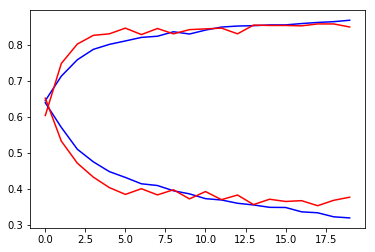

In [5]:
plt.plot(resultA.history['acc'],'b')
plt.plot(resultA.history['val_acc'],'r')
plt.plot(resultA.history['loss'],'b')
plt.plot(resultA.history['val_loss'],'r')
plt.show()

# Train Model B

In [6]:
#img gen
trainGen600 = train_datagen.flow_from_directory(
        r'.\data\resize\train',
        target_size=(600,800),
        batch_size=4,
        seed = seed,
        class_mode='categorical')

valicGen600 = valic_datagen.flow_from_directory(
        r'.\data\resize\valic',
        target_size=(600,800),
        batch_size=4,
        seed = seed,
        class_mode='categorical')

Found 1804 images belonging to 2 classes.
Found 218 images belonging to 2 classes.


In [7]:
#set model layers
modelB = InceptionResNetV2(include_top=False,weights='imagenet',input_shape=(None,None,3))
x = modelB.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5,seed=seed)(x)
predictions = Dense(2, activation='softmax')(x)
modelB = Model(inputs=modelB.input, outputs=predictions)

In [8]:
#train model
resultsB=[]
optimizer = SGD(lr=0.001, momentum=0.9,  decay=1e-6, nesterov=True)
modelB.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

filepath=r"./h5/resize600-{epoch:02d}-{val_acc:.4f}.h5"
checkpoint= ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list= [checkpoint]

resultB = modelB.fit_generator(
        trainGen600,
        epochs=10,verbose=1,
        callbacks=callbacks_list,
        validation_data=valicGen600,
        class_weight='auto')
resultsB.append(resultB)

Epoch 1/10
451/451 [==============================] - 298s 660ms/step - loss: 0.6315 - acc: 0.6624 - val_loss: 0.6051 - val_acc: 0.6972

Epoch 00001: val_acc improved from -inf to 0.69725, saving model to ./h5/resize600-01-0.6972.h5
Epoch 2/10
451/451 [==============================] - 255s 566ms/step - loss: 0.5522 - acc: 0.7445 - val_loss: 0.5575 - val_acc: 0.7569

Epoch 00002: val_acc improved from 0.69725 to 0.75688, saving model to ./h5/resize600-02-0.7569.h5
Epoch 3/10
451/451 [==============================] - 256s 567ms/step - loss: 0.4509 - acc: 0.8099 - val_loss: 0.4725 - val_acc: 0.8073

Epoch 00003: val_acc improved from 0.75688 to 0.80734, saving model to ./h5/resize600-03-0.8073.h5
Epoch 4/10
451/451 [==============================] - 256s 567ms/step - loss: 0.4213 - acc: 0.8282 - val_loss: 0.3943 - val_acc: 0.8211

Epoch 00004: val_acc improved from 0.80734 to 0.82110, saving model to ./h5/resize600-04-0.8211.h5
Epoch 5/10
451/451 [==============================] - 256s 

In [20]:
modelB.save_weights(r'./h5/resize600.h5')

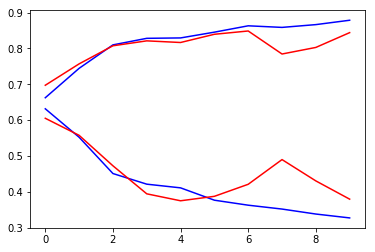

In [9]:
plt.plot(resultB.history['acc'],'b')
plt.plot(resultB.history['val_acc'],'r')
plt.plot(resultB.history['loss'],'b')
plt.plot(resultB.history['val_loss'],'r')
plt.show()

# Test A

In [10]:
from tqdm import tqdm

testDir = r'.\test\testa'
imgPathList = search_dir(testDir, 'jpg')
xmlPathList = search_dir(testDir, 'xml')
xmlNameList = [os.path.split(xmlPath)[1][:-4] for xmlPath in xmlPathList]
yList = []
for imgPath in imgPathList:
    imgname = os.path.split(imgPath)[1]
    if imgname[:-4] in xmlNameList:
        yList.append(1)
    else:
        yList.append(0)

pArrayListA = []
pListB = []
for imgPath in tqdm(imgPathList):
    pArrayA = predictCutPic(imgPath,320,320,160,modelA,padding=False,paddingSize=160)
    pB = predictFullPic(imgPath,modelB)
    pArrayListA.append(pArrayA)
    pListB.append(pB)

100%|████████████████████████████████████████████████████████████████████████████████| 662/662 [27:19<00:00,  2.48s/it]


auc: 0.951915


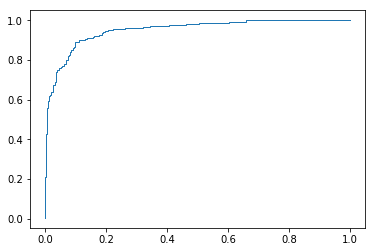

In [11]:
pListA = [np.mean(np.sort(pArray)[-3:]) for pArray in pArrayListA]
pList = [0.5*pA+0.5*pB for pA,pB in zip(pListA,pListB)]

auc = plt_auc(pList, yList)

In [17]:
import datetime
#save test data to csv
pList = deal_pList(pList)
predictDf = pd.DataFrame()
predictDf['filename'] = [os.path.split(imgPath)[1] for imgPath in imgPathList]
predictDf['probability'] = pList
predictDf.to_csv(r'.\submit\submit_'+datetime.datetime.now().strftime('%Y%m%d_%H%M%S') + '.csv', header=None, index=False)
print('done')

done


# Test B

In [12]:
from tqdm import tqdm

testDir = r'.\test\testb'
imgPathList = search_dir(testDir, 'jpg')
xmlPathList = search_dir(testDir, 'xml')
xmlNameList = [os.path.split(xmlPath)[1][:-4] for xmlPath in xmlPathList]
yList = []
for imgPath in imgPathList:
    imgname = os.path.split(imgPath)[1]
    if imgname[:-4] in xmlNameList:
        yList.append(1)
    else:
        yList.append(0)

pArrayListA = []
pListB = []
for imgPath in tqdm(imgPathList):
    pArrayA = predictCutPic(imgPath,320,320,160,modelA,padding=False,paddingSize=160)
    pB = predictFullPic(imgPath,modelB)
    pArrayListA.append(pArrayA)
    pListB.append(pB)

100%|████████████████████████████████████████████████████████████████████████████████| 647/647 [26:37<00:00,  2.47s/it]


auc: 0.953338


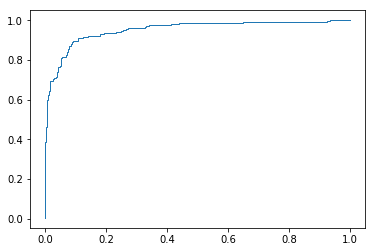

In [13]:
pListA = [np.mean(np.sort(pArray)[-3:]) for pArray in pArrayListA]
pList = [0.5*pA+0.5*pB for pA,pB in zip(pListA,pListB)]

auc = plt_auc(pList, yList)

In [18]:
import datetime
#save test data to csv
pList = deal_pList(pList)
predictDf = pd.DataFrame()
predictDf['filename'] = [os.path.split(imgPath)[1] for imgPath in imgPathList]
predictDf['probability'] = pList
predictDf.to_csv(r'.\submit\submit_'+datetime.datetime.now().strftime('%Y%m%d_%H%M%S') + '.csv', header=None, index=False)
print('done')

done
